# Модуль 3. Разметка данных
---
## Федоров Георгий

In [1]:
import praw
import os
import random
from PIL import Image
import re
import json
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import polars as pl
from tqdm import tqdm
import seaborn as sns

from IPython.display import clear_output

Помимо текстов (и в будущем картинок) нам важно понимать тип задачи редактирования (н., добавление объекта, смена цвета, реставрация фото, ...) \
К сожалению, живые запросы часто слишком нетривиальные, чтобы можно было извлечь тип запроса из текста по ключевым словам. \
Поэтому давайте посмотрим, как с этим может справиться живой разметчик.

In [2]:
df = pd.read_csv('posts_clean_fin.csv').drop(columns='Unnamed: 0')
df

,link_flair_text,url,link_flair_css_class,id,created_utc,title,author,selftext,domain,num_comments,score,is_reddit_media_domain,total_awards_received,upvote_ratio,src,fulltext,text_len,is_popular
0,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9fi1,1.340080e+09,Can someone edit this picture for me?,[deleted],This is probably a stupid thing to ask as it s...,self.PhotoshopRequest,0.0,1.0,1.0,NaN,NaN,archive,Can someone edit this picture for me?; This is...,617.0,False
1,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9h62,1.340082e+09,Can someone edit this pic for me?,UnknownReddit007,This is probably a stupid thing to ask as it s...,self.PhotoshopRequest,0.0,1.0,1.0,NaN,NaN,archive,Can someone edit this pic for me?; This is pro...,529.0,False
2,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,x43s2,1.343189e+09,Need Subreddit Mascot,nismomonkey,Looking for a Reddit Alien for our new Subredd...,self.PhotoshopRequest,0.0,1.0,1.0,NaN,NaN,archive,Need Subreddit Mascot; Looking for a Reddit Al...,266.0,False
3,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10by6r,1.348378e+09,Can you create a logo for my brand?,Aerimae,NaN,self.PhotoshopRequest,0.0,1.0,1.0,NaN,NaN,archive,Can you create a logo for my brand?,35.0,False
4,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10ev4t,1.348521e+09,I need to make a joke Birthday present for a f...,[deleted],Id like to put this funny-looking picture of m...,self.PhotoshopRequest,0.0,1.0,1.0,NaN,NaN,archive,I need to make a joke Birthday present for a f...,238.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522211,Free :snoo:,https://i.redd.it/3riv5d9s1yue1.jpeg,free,1jzl4db,1.744699e+09,Remove my double chin,divinemissn,My double chin here is disgusting but I want t...,i.redd.it,5.0,1.0,1.0,0.0,1.00,api,Remove my double chin; My double chin here is ...,149.0,False
522212,Free :snoo:,https://www.reddit.com/gallery/1jzl7hk,free,1jzl7hk,1.744699e+09,Family think this is my doppelgänger from history,ResponsibleSpread8,Hi so first pic is me and the old one is a ran...,reddit.com,2.0,4.0,0.0,0.0,1.00,api,Family think this is my doppelgänger from hist...,241.0,False
522213,Paid :redditgold:,https://i.redd.it/qybbrmg23yue1.jpeg,paid,1jzl83s,1.744699e+09,"Hi, turn these people into pirates, don't hesi...",FromBZH-French,NaN,i.redd.it,6.0,1.0,1.0,0.0,1.00,api,"Hi, turn these people into pirates, don't hesi...",94.0,False
522214,Paid :redditgold:,https://www.reddit.com/r/PhotoshopRequest/comm...,paid,1jzleq1,1.744700e+09,Swap Disney words,Visible_Dealer_5815,I have two PNG image files related to a Disney...,self.PhotoshopRequest,15.0,2.0,0.0,0.0,1.00,api,Swap Disney words; I have two PNG image files ...,219.0,False


In [3]:
df['task'] = ''

Полистав произвольные запросы, я составил примерный список задач, \
которые требуются людям - это будут наши классы:
```
remove
enhance colors
replace text
replace
remove bg
memorial
change color
add
vague
deblur
makeup
stylize
enhance image
better
upscale
change clothes
change size
outline
restore photo
remove text
change bg
add clothes
change
profile
blur
move
change expression
face swap
colorize
age
change hair
remove watermarks
thinner
```

In [57]:
# добавил ещё, сгруппировал
types = {
'addition': [
    'add',
    'add clothes',
    'add text'
],

'removal': [
    'remove',
    'remove bg',
    'remove text',
    'remove watermarks'
],

'replacing': [
    'replace',
    'replace text'
],

'changing': [
    'change',
    'change color',
    'change size',
    'change clothes',
    'change expression',
    'change hair',
    'change bg',
    'change weather',
    'change season',
    'change time',
    'move',
    'face swap'
],

'enhancing': [
    'enhance colors',
    'enhance image',
    'deblur',
    'blur',  
    'restore photo',
    'colorize',
    'better',
    'upscale',
    'filter',
    'outline',
    'stylize'
],

'common': [
    'memorial',
    'profile'
],

'person': [
    'makeup',
    'age',
    'muscular',
    'thinner'
]
}

In [20]:
# сэмплируем часть датасета, которую будем размечать
df_sample = df.sample(239)[['id', 'fulltext', 'task']]
df_sample

,id,fulltext,task
3645,223sb1,Can someone please help recreate this logo?; F...,
8272,2ctbpa,Could someone please remove the captions from ...,
9457,2ekoxi,Face swap please!!!; URL_PLACE,
12532,2j5dqd,Fear Cuts Deeper than swords; Could someone pl...,
16517,2osuwg,"Circle of stars anyone?; Hello, I'm coming up ...",
...,...,...,...
518540,1hlu8dl,Please help my friends mom recreate a lost pho...,
519623,1ho6uyu,"Can someone please remove all the text, geotag...",
521095,1jj1k5v,More DPI and sizing request; Friends cat passe...,
521146,1jk2v67,Can someone make the color of the neck of my d...,


Не вышло договориться о разметке с кем-то из нашей группы, поэтому я попрошу друга. \
Поскольку разметчик будет только 1, единственный вариант замера качества - это ханипоты.

Так что я сейчас возьму 39 произвольных строк и вручную дам им классы.

In [ ]:
# размечаю ханипоты
# (вывода ячейки нет из-за clear_output, который я использую, чтобы было удобнее)
for i, row in df_sample.sample(39).iterrows():
    clear_output()
    print(f'sample {i}')
    print(row['fulltext'])
    df_sample.loc[i, 'task'] = input()

In [23]:
# вот что у меня вышло
df_sample[df_sample['task'] != '']

,id,fulltext,task
319389,wgfcnn,Help sought to create Police Department Patch ...,vague
371628,16ec86f,Requesting color and clarity ✨️ $10 for best q...,"enhance image, colorize"
372869,16h7o8p,10$ for who can remove the signs from this lan...,remove
232370,euhfal,Can someone photoshop my nephew in a dance gro...,vague
205734,ca4k7a,Anyone able to fix this up?,vague
29495,3a3q01,Can someone please remove the front bars in th...,remove
91433,5mnjvb,Could someone crop my dogs head onto the body ...,add clothes
172095,9gz4gr,Can someone please photoshop a photo of Uranus...,vague
321363,wxho33,Can anyone clean up this photo of my mother-in...,restore photo
225629,e8c6nz,Can someone add Joker makeup to baby Yoda? Som...,makeup


In [26]:
# запомним индексы ханипотов:
df_sample[df_sample['task'] != ''].index

Index([319389, 371628, 372869, 232370, 205734,  29495,  91433, 172095, 321363,
       225629, 312150, 362186, 516521, 300215, 468184, 156399, 214256,  69614,
        67349, 377725,  62652, 152904, 175302, 420332, 350404, 430909, 435340,
       193238, 458839, 323130, 162585, 327084, 149976, 468472, 106002, 440099,
       214147, 483040, 459568],
      dtype='int64')

In [27]:
# теперь сохраним данные для разметчика
df_sample[['id', 'fulltext']].to_csv('to_markup.csv')

Я не настолько знаком с сервисами разметки, чтобы делать гибкую настройку с удобным расположением типов операций, да и сабсет для разметки небольшой...

Поэтому я набросал .py-файл с интерфейсом в gradio (см. в папке HW3, рядом с этим блокнотом). Разметчик скачает .py-файл и .csv-табличку, запустит файл, разметит и отправит результирующий .csv мне.

Инструкция лежит в .md-файлике рядом, вот она еще раз:

## Инструкция по разметке классов фотошоп-запросов

Привет!

Положи, пожалуйста, файлики `markup_gradio.py` и `to_markup.csv` в одну папку,\
затем запусти скрипт:
```commandline
chmod +x ./markup_gradio.sh
python markup_gradio.sh
```
Это gradio-интерфейс, он развернётся на localhost и напишет, по какому порту.\
Перейдя по ссылке, ты попоадёшь в следующий интерфейс:

Сверху будет блок `Инструкция`, в нём будет  текст фотошоп-запроса на английском.

Затем будут кнопки, сгруппированные в 7 категорий вот так:

## addition
    'add' - добавление чего-либо
    'add clothes' - добавление именно одежды
    'add text' - добавление текста

## removal
    'remove' - удаление чего-либо
    'remove bg' - удаление фона
    'remove text' - удаление текста
    'remove watermarks - удаление ватермарок

## replacing
    'replace' - заменить что-то на что-то
    'replace text' - заменить один текст на другой

## changing
    'change' - изменить что-то
    'change color' - перекрасить что-то
    'change size' - сделать что-то больше/меньше
    'change clothes' - поменять одежду
    'change expression' - сменить выражение лица
    'change hair' - изменить волосы/причёску
    'change bg' - сменить фон
    'change weather' - смена погоды
    'change season' - смена сезона
    'change time' - смена времени суток
    'move' - передвинуть что-то
    'face swap' - поменять лица местами

## enhancing
    'enhance colors' - усилить/сбалансировать цвета
    'enhance image' - общее улучшение изображения
    'deblur' - убрать размытие
    'blur' - добавить размытие 
    'restore photo' - реставрация старых фото
    'colorize' - колоризация монохромных фото
    'better' - запрос типа "сделай лучше"
    'upscale' - увеличение разрешения
    'outline' - обводка чего-то
    'stylize' - стилизация (нарисуй в таком-то стиле)
    'filter' - наложи какой-нибудь фильтр

## common
    'memorial' - улучшение портрета и придание ему эстетичного, памятного вида 
    'profile' - улучшение портрета и придание ему формального вида, как на документы

## person
    'makeup' - нанесение/улучшение/изменение макияжа
    'age' - смена возраста (старение/омоложение)
    'muscular' - накачать мышцы
    'thinner' - сбросить лишний вес человеку, сделать стройнее


Нужно нажать на все кнопки, которые отражают запрашиваемые в тексте изменения.

Это может быть только одна кнопка, может быть несколько...

> Есть ряд ситуаций, когда не стоит выбирать ни одну категорию, а просто нажать "Далее":
> - это не запрос, а что-то непонятное\
>  *(Download Adobe InDesign CC 2017 Full Crack - Hướng dẫn chi tiết cài đặt)*
> - запрос не на редактирование одного фото (несколько фото, создание с нуля, и т.д.)
>  
> - запрос слишком абстрактный, не понятно, что нужно делать\
> *([Specific] Black and Gold Gunner Custom)*
> - запрос слишком сложный (очень много операций, работа с несколькими фото, супер-сложные подробности)\
> *(I am having an all girls youth wrestling tournament in Dec. I am trying to create singlets for the first 50 to sign up. I would like to have the text removed, the border turned to yellow and the girl wrestlers left and everything besides the border and girl wrestlers to be transparent. Thank you!)*
> - запрос абсурдный\
> *([Random] Please photoshop my mates neck so it becomes a bendy snake with his face/head still on the end. If you could get "U Wot m8" coming out his mouth that would be even better.)*

Как только появится завершающий экран, в папку со скриптом сохранится файл `done_markup.csv`.\
Отправь его мне пожалуйста!

### Спасибо за работу!)

---
отправил другу, жду...

---
дождался, вот его фидбек:

> Привет, вроде разметил, прикрепляю файлик!
> Вроде всё круто, если и есть что сказать, товот:
> 1. это же запросы с картинками вместе? Может, ты бы их с картинками вместе показывал?
> 2. некоторые предложенные тобой классы довольно похожи, и взаимозаменяемы
> 3. доаольно много не получают никакого  класса - либо непонятные, либо слишком сложные, либо абсурдные
> 4. есть у тебя супер-узкие классы, мне они вообще будто почти не попались
>
> Так-то вроде и всё

Разберу фидбек в конце блокнота, а пока нужно замерить качество

In [49]:
# загружаем разметку
df = pd.read_csv('done_markup.csv', index_col=0)
df

,id,fulltext,task
3645,223sb1,Can someone please help recreate this logo?; F...,vague
8272,2ctbpa,Could someone please remove the captions from ...,remove text
9457,2ekoxi,Face swap please!!!; URL_PLACE,face swap
12532,2j5dqd,Fear Cuts Deeper than swords; Could someone pl...,vague
16517,2osuwg,"Circle of stars anyone?; Hello, I'm coming up ...",vague
...,...,...,...
518540,1hlu8dl,Please help my friends mom recreate a lost pho...,face swap
519623,1ho6uyu,"Can someone please remove all the text, geotag...",remove text
521095,1jj1k5v,More DPI and sizing request; Friends cat passe...,upscale
521146,1jk2v67,Can someone make the color of the neck of my d...,change color


In [50]:
# загружаем ханипоты
df_pots = pd.read_csv('markup_honeypots.csv', index_col=0)
df_pots

,id,fulltext,task
3645,223sb1,Can someone please help recreate this logo?; F...,NaN
8272,2ctbpa,Could someone please remove the captions from ...,NaN
9457,2ekoxi,Face swap please!!!; URL_PLACE,NaN
12532,2j5dqd,Fear Cuts Deeper than swords; Could someone pl...,NaN
16517,2osuwg,"Circle of stars anyone?; Hello, I'm coming up ...",NaN
...,...,...,...
518540,1hlu8dl,Please help my friends mom recreate a lost pho...,NaN
519623,1ho6uyu,"Can someone please remove all the text, geotag...",NaN
521095,1jj1k5v,More DPI and sizing request; Friends cat passe...,NaN
521146,1jk2v67,Can someone make the color of the neck of my d...,NaN


In [52]:
len(df_pots[df_pots['task'].notna()])

39

In [71]:
print(all(df.index == df_pots.index))

True


Дубликатов и выбросов быть не может по специфике задачи\
Но если что-то будет не так - заметим дальше

In [53]:
# объединим сеты
df_honeypots = df.merge(df_pots[['id', 'task']], on='id', suffixes=('_pred', '_true'))
df_honeypots = df_honeypots.dropna(subset=['task_true'])

In [54]:
# приведём мультивыборы к единому виду
def parse_labels(label):
    if pd.isna(label):
        return set()
    return set(label.split(', '))

df_honeypots['set_pred'] = df_honeypots['task_pred'].apply(parse_labels)
df_honeypots['set_true'] = df_honeypots['task_true'].apply(parse_labels)

In [55]:
# 1. Accuracy
df_honeypots['exact_match'] = df_honeypots.apply(lambda row: row['set_pred'] == row['set_true'], axis=1)
exact_accuracy = df_honeypots['exact_match'].mean()
print(f"accuracy: {exact_accuracy:.2%}")

accuracy: 82.05%


In [56]:
# 2. попадание хотя бы одним типом из нескольких
df_honeypots['any_overlap'] = df_honeypots.apply(lambda row: len(row['set_pred'] & row['set_true']) > 0, axis=1)
partial_accuracy = df_honeypots['any_overlap'].mean()
print(f"partial accuracy: {partial_accuracy:.2%}")

partial accuracy: 82.05%


In [59]:
# 3. попадание в верхнеуровневую группу
group_map = {}
for group, labels in types.items()
    for label in labels:
        group_map[label] = group

def get_group_set(label_set):
    return set(group_map.get(label, 'Unknown') for label in label_set)

df_honeypots['group_pred'] = df_honeypots['set_pred'].apply(get_group_set)
df_honeypots['group_true'] = df_honeypots['set_true'].apply(get_group_set)
df_honeypots['group_match'] = df_honeypots.apply(lambda row: len(row['group_pred'] & row['group_true']) > 0, axis=1)
group_accuracy = df_honeypots['group_match'].mean()


print(f"upper accuracy: {group_accuracy:.2%}")

upper accuracy: 87.18%


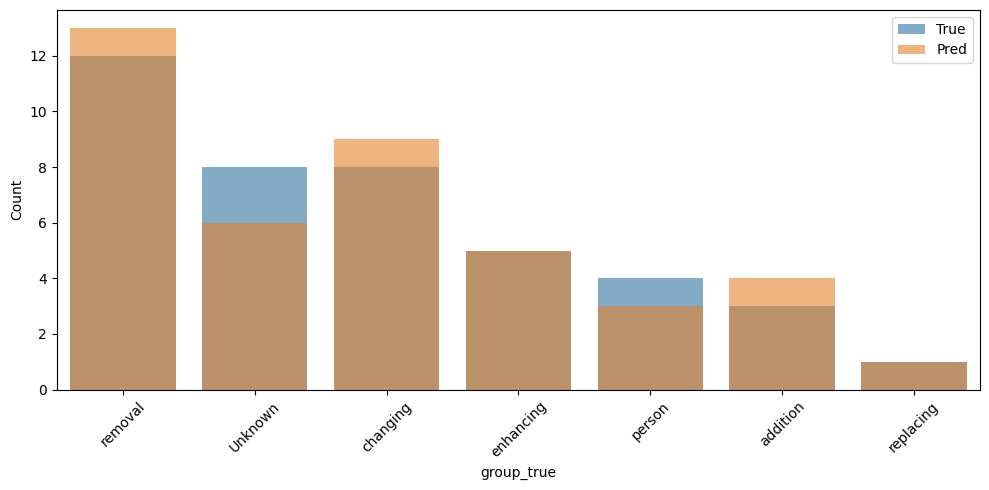

In [61]:
# посмотрим проблемы по верхнеуровневым группам
true_group_counts = df_honeypots['group_true'].explode().value_counts()
pred_group_counts = df_honeypots['group_pred'].explode().value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=true_group_counts.index, y=true_group_counts.values, alpha=0.6, label='True')
sns.barplot(x=pred_group_counts.index, y=pred_group_counts.values, alpha=0.6, label='Pred')
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Неплохо, но сложно что-то сказать так. \
Ханипотов было мало, так что 20% проблем можно глянуть и вручную:

In [67]:
for _, row in df_honeypots[~df_honeypots['exact_match']].iterrows():
    print('\nЗапрос:')
    print(row['fulltext'])
    print(f'pred: {row["set_pred"]}')
    print(f'true: {row["set_true"]}')


Запрос:
Make this baby into “superbaby”?
pred: {'change'}
true: {'vague'}

Запрос:
could someone remove the sad face made by my friends stomach in this otherwise lovely photo x
pred: {'remove'}
true: {'change'}

Запрос:
Can someone add Joker makeup to baby Yoda? Somehow no one’s done this yet.
pred: {'add'}
true: {'makeup'}

Запрос:
Can anyone clean up this photo of my mother-in- law? she is celebrating her 70th birthday soon.
pred: {'enhance image'}
true: {'restore photo'}

Запрос:
Can someone close the lip please :D?; URL_PLACE


pred: {'change'}
true: {'change expression'}

Запрос:
Can anyone fix eyeballs/pupils 
pred: {'change'}
true: {'better'}

Запрос:
Can you photoshop my wedding pictures?
pred: {'better'}
true: {'vague'}


Итак, разница объяснима следующим:
1. есть неоднозначные инструкции, которые можно отнести к близким по смыслу видам
2. грань между возможностью выбрать вид и невозможностью определиться ('vague') бывает тонка.

## Выводы
---

- [x]  Взял датасет из предыдущих ДЗ
- [x]  Написал ТЗ в свободной форме для разметки текстов по типам операций, см. .md-файл. В большинстве случаев задание тривиальное и примеры только загрузят и усложнят ТЗ, так что примеры включил только в нетривиальной ситуации (в конце, как понять, что пример не классифицируем).
- [x]  Разметчик один, поэтому в качестве валидации самостоятельно разметил несколько ханипотов.
- [x]  Отправьте датасет и ТЗ другу (на курсе не успел никого найти). Для разметки написал ему gradio-интерфейс, прикладываю его в папку с ДЗ. Получил обратную связь, разберу её по пунктам:

> 1. это же запросы с картинками вместе? Может, ты бы их с картинками вместе показывал?

Хорошее замечание. Да, с картинками будет больше вес, но качество правда может возрасти. Проблема в том, что значительная часть текстов в датасете уже не имеет картинок (посты/ссылки уже давно удалены/неактивны, живы только метаданные в архиве).  К тому же, по моему опыту, хороший запрос однозначно понятен и без картинки

> 2. некоторые предложенные тобой классы довольно похожи, и взаимозаменяемы

Тоже хорошее замечание, наверное я перегнул со спецификой классов. Однако в качестве решения я добавил их группировку в классы верхнего уровня, что решает проблему.

> 4. доаольно много не получают никакого  класса - либо непонятные, либо слишком сложные, либо абсурдные

Правда, к сожалению, но тут ничего не поделаешь - в сырых данных из интернета много мусора.

> 6. есть у тебя супер-узкие классы, мне они вообще будто почти не попались

Это специфика размеров датасета, 200-300 примеров - не так много. Однако узконаправленные классы важны, иначе модель просто им не научится.


- [x]  Проанализировал полученные результаты разметки. Выбросов/дубликатов/некорректных результатов не обнаружил. Оценил различные accuracy разметчика на подмешанных тестовых кейсах. Разметчик отработал прекрасно, нареканий нет)
- [x]  На тему процесса разметки данных и качества полученных результатов:
> У меня есть опыт управления разметчиками на работе, потому могу сказать, что разметка - это гораздо сложнее, чем "вот сейчас 10 копий меня решат мои задачи в 10 раз быстрее". И дело даже не в интеллекте или навыках - а в различном субъективном понимании. Очень важно максимально ясными и простыми ставить задачи и ТЗ. Постоянно контролировать процесс, получать обратную связь, проверять качество на ханипотах, на метриках согласованности, и т.д.
> И всё же хорошо организованный процесс даёт эффективность, незаменимую никакими SOTA-моделями-разметчиками